**Importing Libraries**

In [42]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import joblib

# Sklearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, power_transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


**Loading the dataset**

In [29]:
zip_path = r"C:\Users\Welcome Sir\Downloads\playground-series-s5e11.zip"

with ZipFile(zip_path, "r") as zip_ref:
    zip_ref.printdir()

File Name                                             Modified             Size
sample_submission.csv                          2025-10-28 23:08:48      2291139
test.csv                                       2025-10-28 23:08:48     23021430
train.csv                                      2025-10-28 23:08:50     55988519


In [30]:
# Loading the "test" and "train" data

with ZipFile(zip_path) as z:
    with z.open('train.csv') as f:
        train_data = pd.read_csv(f)
        print("\nTrain data successfully loaded...")
        
    with z.open('test.csv') as f:
        test_data = pd.read_csv(f)
        print("\nTest data successfully loaded...")


Train data successfully loaded...

Test data successfully loaded...


In [31]:
# Making a copy of the data
train_df = train_data.copy()
test_df = test_data.copy()

**From the EDA, `Power transformation` from recommended**

In [32]:
# Let's split our data
X = train_df.drop(columns=['loan_paid_back', 'id'])
y = train_df['loan_paid_back']

# Let's do the same to the test data
test_df = test_df.drop(columns='id')

In [33]:
# Let's reduce the skewness of the numerical columns using power transformation
def handle_skewness(df, columns:dict):
    df = df.copy()
    df[columns] = power_transform(df[columns], method='yeo-johnson')
    return df

# Let's treat the skewness of numerical in X
num_col = X.select_dtypes(include='number').columns
X = handle_skewness(X, num_col)


# Let's do same for the test data as well.
test_num_col = test_df.select_dtypes(include='number').columns
test_df = handle_skewness(test_df, test_num_col)

**Encoding Categorical Data**

In [34]:
cat_col = train_df.select_dtypes(include='object').columns
cat_col

Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object')

In [35]:
# One hot encoding categorical columns
def one_hot_encoder(df, columns:dict):
    df = df.copy()
    df = pd.get_dummies(df, columns=columns, drop_first=True)
    return df

# based on EDA column to be encoded [gender,marital_status,employment_status]
cat=['gender','marital_status','employment_status','loan_purpose']
X= one_hot_encoder(X, cat)

# let one hot encode the categorical columns in test data too
test_data= one_hot_encoder(test_data, cat)

In [36]:
# manual encoding target column [education_level,grade_subgrade]
def manual_encoder(df, column:str, mapping:dict):
    df=df.copy()
    df[column]= df[column].map(mapping)
    return df

In [37]:
# encoding education_level
edu_order = {
    "High School": 1,
    "Bachelor's": 2,
    "Master's": 3,
    "PhD": 4,
    "Other": 0
}
X= manual_encoder(X, 'education_level', edu_order)

# let manual encode education_level in test data too
test_data= manual_encoder(test_data, 'education_level', edu_order)

In [38]:
# Encoding grade_subgrade
grade_order = [
    'A1','A2','A3','A4','A5',
    'B1','B2','B3','B4','B5',
    'C1','C2','C3','C4','C5',
    'D1','D2','D3','D4','D5',
    'E1','E2','E3','E4','E5',
    'F1','F2','F3','F4','F5']

grade_mapping= {grade: idx+1 for idx, grade in enumerate(grade_order)}
X= manual_encoder(X, 'grade_subgrade', grade_mapping)

# let manual encode grade_subgrade in test data too
test_data= manual_encoder(test_data, 'grade_subgrade', grade_mapping)


**Scaling**

In [39]:

# let scale the numerical columns using minmax scaler 
scaler= MinMaxScaler()
X[num_col]= scaler.fit_transform(X[num_col])

# let scale the numerical columns in test data too
test_data[num_col]= scaler.transform(test_data[num_col])

**Splitting the dataset**

In [40]:
# Splitting the dataset into training and testing sets
X_scaled= X[num_col]
X_train, X_val, y_train, y_val= train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

**Building and comparing Multiple Models**

Training Logistic Regression...
Logistic Regression Accuracy:0.811


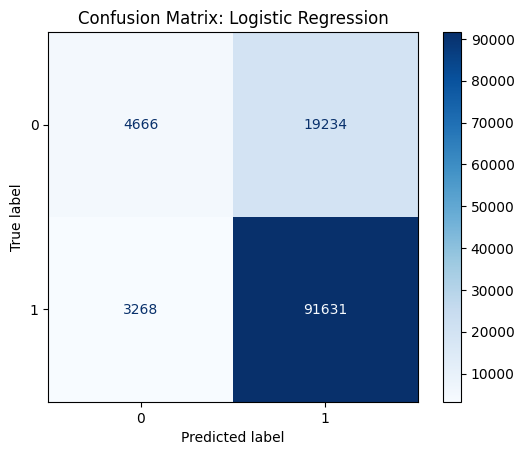

Training Random Forest...
Random Forest Accuracy:0.817


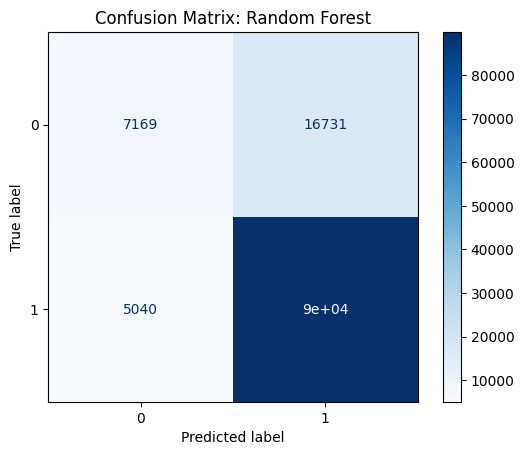

Training Decision Tree...
Decision Tree Accuracy:0.744


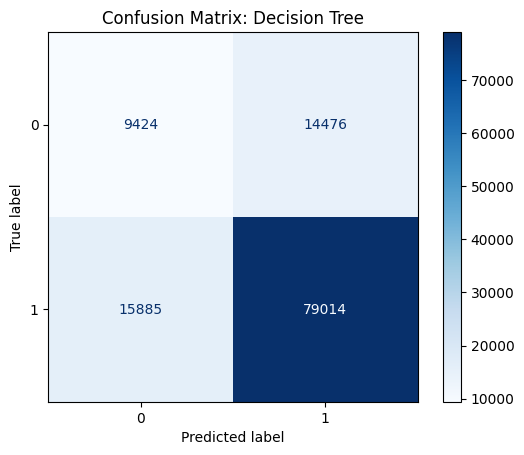

Training KNN...
KNN Accuracy:0.788


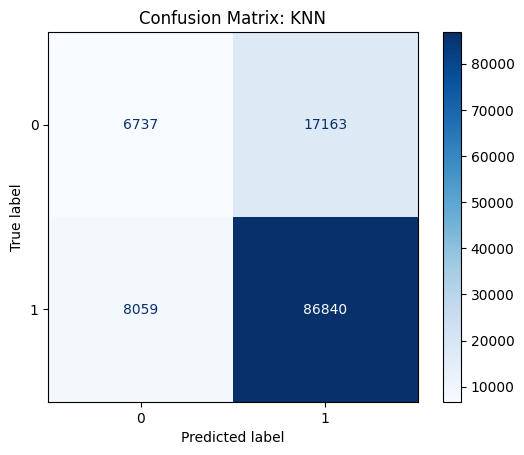

,Model,Accuracy
0,Random Forest,0.816741
1,Logistic Regression,0.810588
2,KNN,0.787692
3,Decision Tree,0.744434


In [44]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=234),
    "Random Forest": RandomForestClassifier(random_state=234),
    "Decision Tree": DecisionTreeClassifier(random_state=234),
    "KNN": KNeighborsClassifier()
}

# Initialize a dictionary to store the models
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    results[model_name] = accuracy
    print(f"{model_name} Accuracy:{accuracy:.3f}")
    
    # Let's include confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Plot with model name as title
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()
    
# Let print the results in a dataframe for better visualization
results_df= pd.DataFrame(results.items(), columns=['Model', 'Accuracy'])
results_df= results_df.sort_values(by='Accuracy', ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df

**Optimize Model Using Randomized Search**

Since `Random Forest` and `Logistic Regression` are very close, I will tune `Random Forest` for stability and interpretability of  feature importance.

In [45]:
# let tune the best trained Model using Random search
rf = RandomForestClassifier(random_state=234, n_jobs=-1)

# parameter random for tuning
# new changes
param_dist = {
    'n_estimators': [100,200,400],
    'max_depth': [8, 12, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# new Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=8,
    scoring='roc_auc',
    cv=3,
    random_state=234,
    n_jobs=-1
)
# Fit on your training data
random_search.fit(X_train, y_train)

print("Best parameters found:")
print(random_search.best_params_)
print(f"Best CV AUC: {random_search.best_score_:.4f}")

# save the best model
best_model = random_search.best_estimator_

Best parameters found:
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 12}
Best CV AUC: 0.7892


In [47]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']